In [2]:
import spotipy as sp
import spotipy.util as util

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


%matplotlib inline
plt.style.use = "default"
%config InlineBackend.figure_format = "retina"

try:
    import seaborn as sb
    sb.set_style('white')
    sb.set_context("notebook")
except:
    pass


def percentile(values, alpha):

    sort = np.sort(values)
    index = alpha * (len(values) - 1)

    # Get floor and ceiling of current index (we will just assume the need to interpolate)
    floor = int(np.floor(index))
    ceil = int(np.ceil(index))

    maxim = ceil - index

    # Set the value as a weighted sum of both values
    interpolation = sort[floor] * maxim + sort[ceil] * (1 - maxim)

    return interpolation


def get_playlist_tracks(username, playlist_id):

    results = s.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    
    while results['next']:
        results = s.next(results)
        tracks.extend(results['items'])
        
    return tracks


def get_track_ids(tracks):
    """Collect all track id's in a list of tracks"""
    
    return [track['track']['id'] for track in tracks]


def get_audio_features(ids):
    """Collect all audio features in a list from a given list of track id's"""
    audio_feats = []

    for i in range(0, len(ids), 100):
        audio_feats += s.audio_features(ids[i:i + 100])

    return audio_feats


def extract_feature(features, feature):
    """
    It's apparently possible for songs to not have a specific feature,
    perhaps these are very old songs ? cannot use a simple list comprehension
    because of it
    """
    f = []
    for track in features:
        if track != None:
            f.append(track[feature])
            
    return f


def hist_of_feature(feat, genre1, genre2):
    """
    Helper function to plot both genre's histogram of a specific feature
    the genre titles are hardcoded
    """
    
    genre1_feat = extract_feature(genre1, feat)
    genre2_feat = extract_feature(genre2, feat)

    plt.figure(figsize=(18, 8))

    plt.subplot(121)
    plt.hist(genre1_feat, normed=True, bins=50)
    plt.title("Feature '{0}' for Country".format(feat))
    plt.xlabel("{0} rating".format(feat))

    plt.subplot(122)
    plt.hist(genre2_feat, normed=True, bins=50)
    plt.title("Feature '{0}' for Hip Hop & R&B".format(feat))
    plt.xlabel("{0} rating".format(feat))

    plt.show()

    return genre1_feat, genre2_feat

In [3]:
SPOTIPY_REDIRECT_URI='http://localhost:8888/callback'
SPOTIPY_CLIENT_SECRET='c02f97ddd119470d8e24b290722c7490'
SPOTIPY_CLIENT_ID='647ffb8c163b4882be0cafe4bf1352d5'
USERNAME='lh7smhcywr18vctg4xmnoehzu'
SCOPE='user-library-read'

token = util.prompt_for_user_token(username=USERNAME,
                           scope=SCOPE,
                           client_id=SPOTIPY_CLIENT_ID,
                           client_secret=SPOTIPY_CLIENT_SECRET,
                           redirect_uri=SPOTIPY_REDIRECT_URI)

In [4]:
s = sp.Spotify(auth=token)

# Collect the total amount of tracks per playlist
country_1 = get_playlist_tracks(12131895985, '4Fzi6FwTsiWkx6wrWkdwTR')
country_2 = get_playlist_tracks(1245377731,  '6TxPbkfT3SfhQ0dHHjHvj9')
hip_hop   = get_playlist_tracks(1279497600, '7lNigxwnh2dbFuKBtgXlys')

# Get the id's per song
country_ids = get_track_ids(country_1) + get_track_ids(country_2)
hiphop_ids  = get_track_ids(hip_hop)

# Get all audio features per id
country_features = get_audio_features(country_ids)
hiphop_features  = get_audio_features(hiphop_ids)

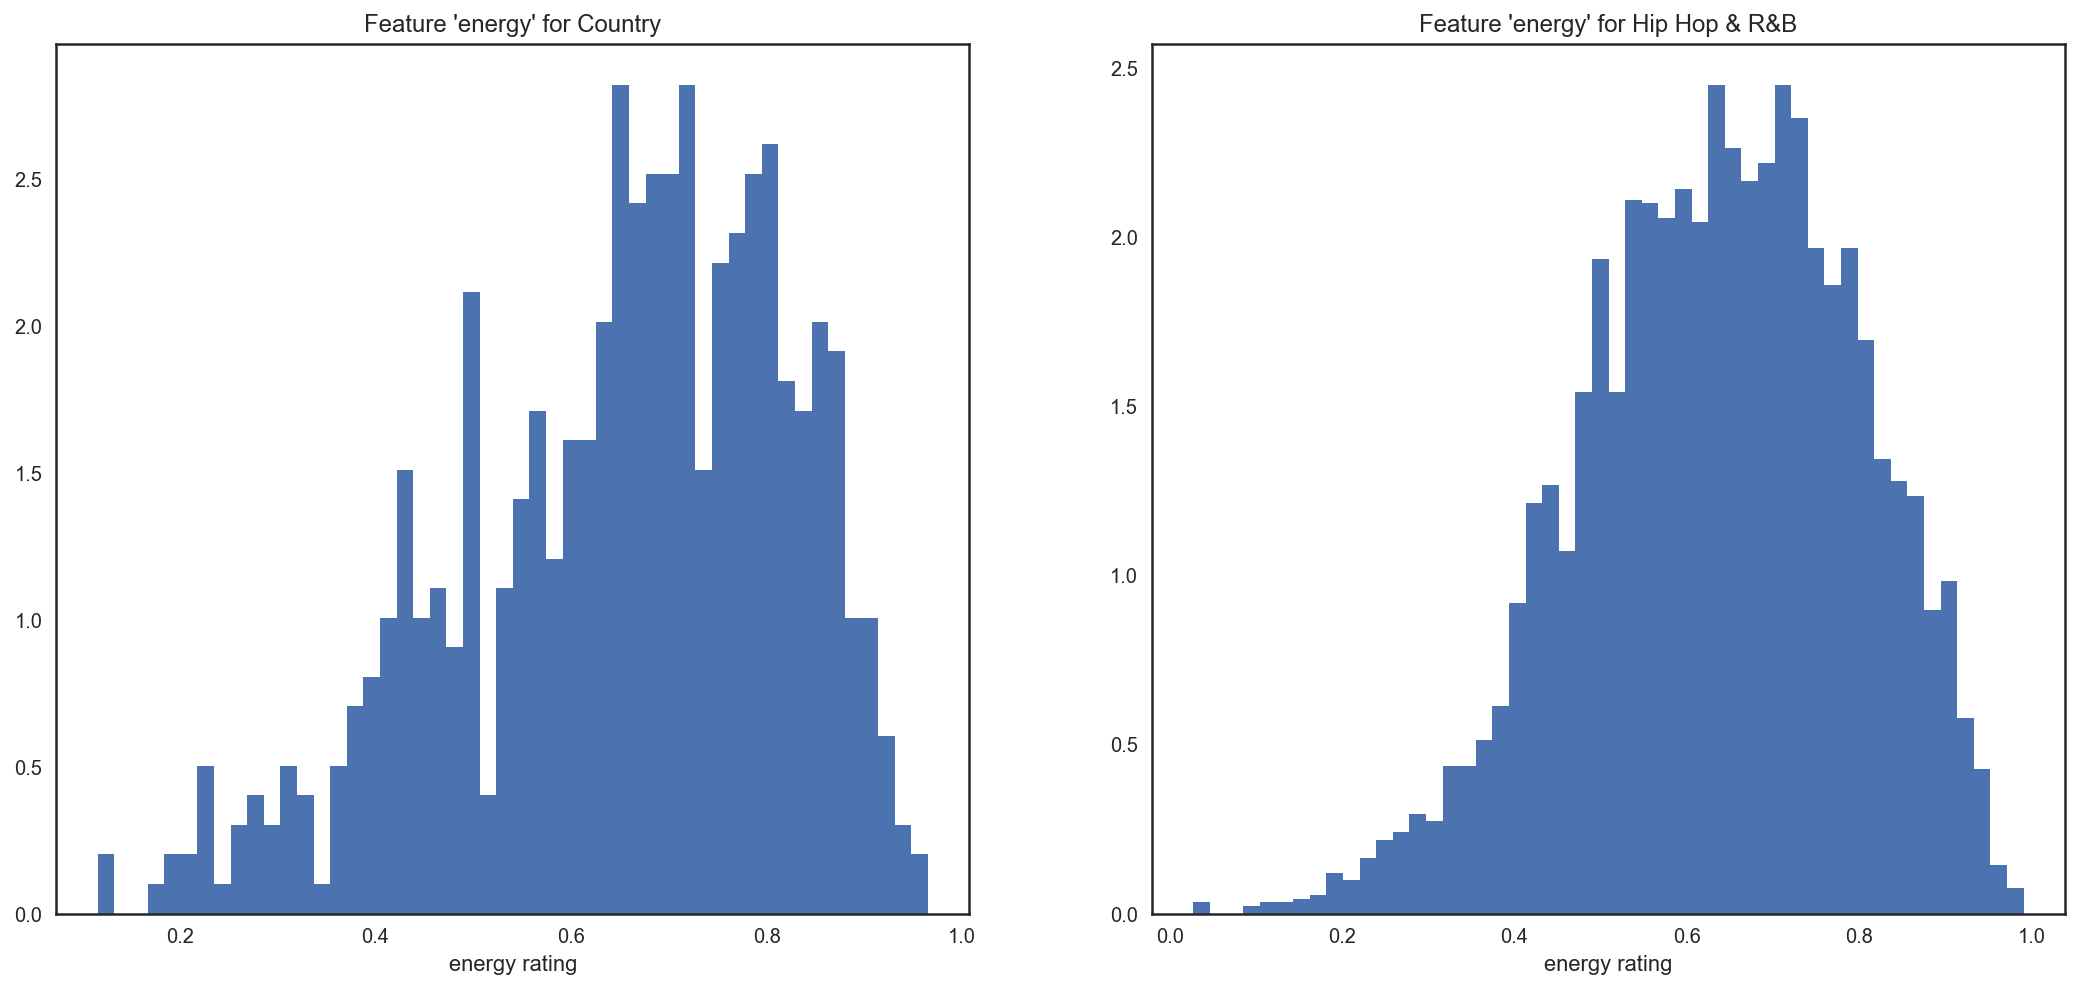

In [314]:
hist_of_feature('energy', country_features, hiphop_features);

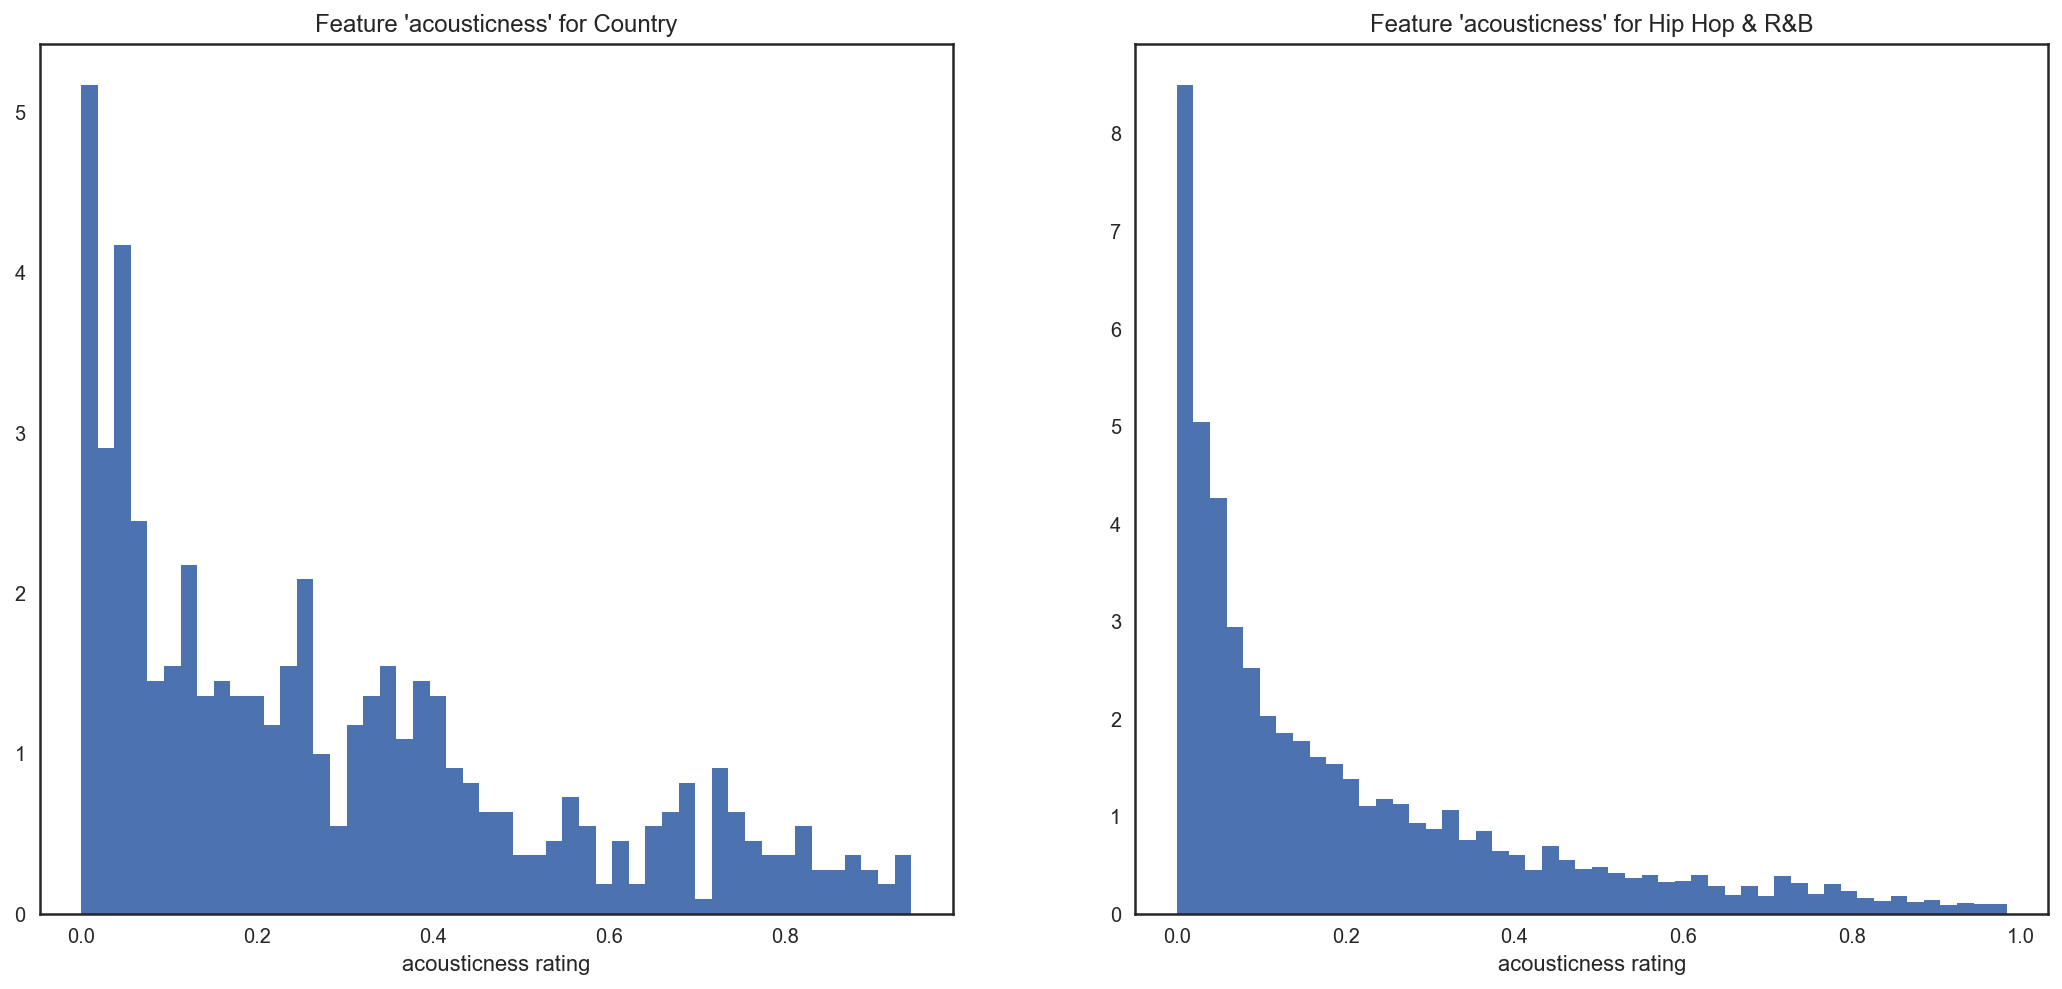

In [315]:
hist_of_feature('acousticness', country_features, hiphop_features);

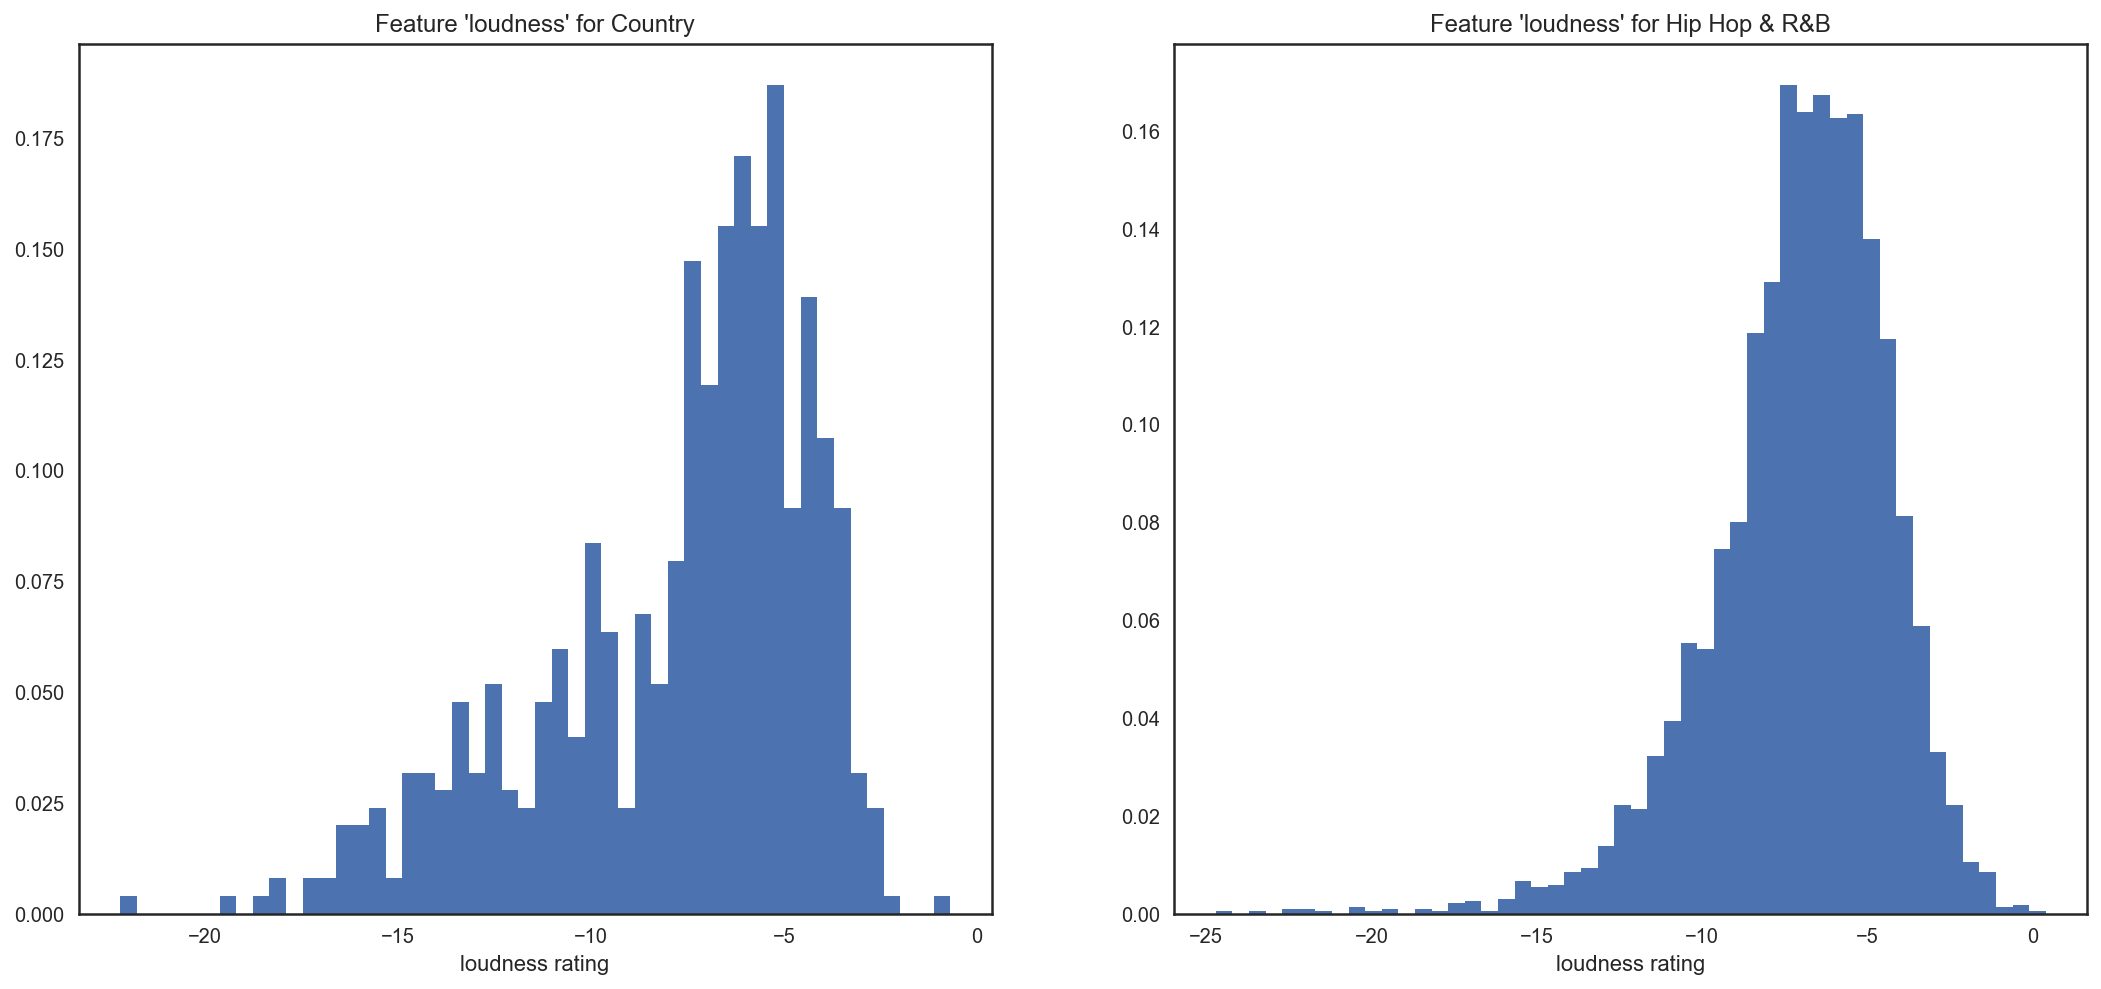

In [316]:
hist_of_feature('loudness', country_features, hiphop_features);

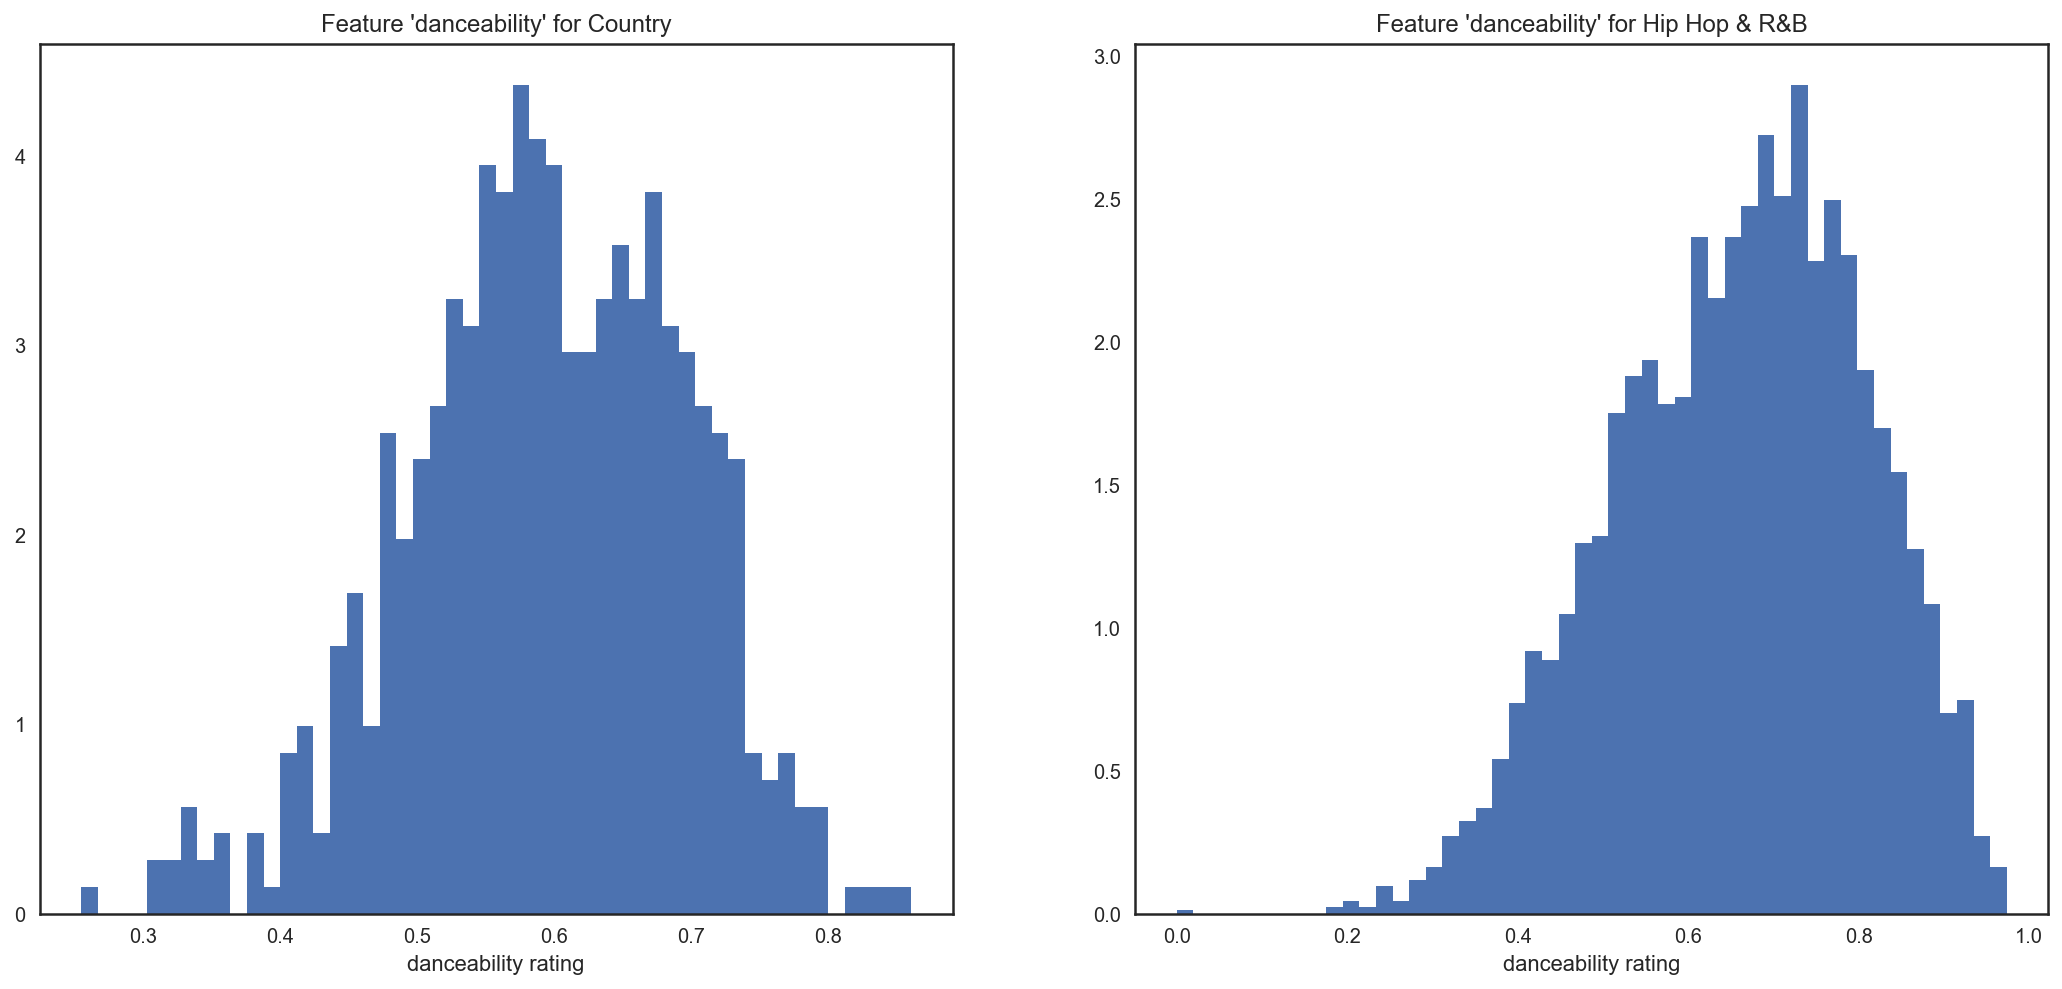

In [317]:
hist_of_feature('danceability', country_features, hiphop_features);

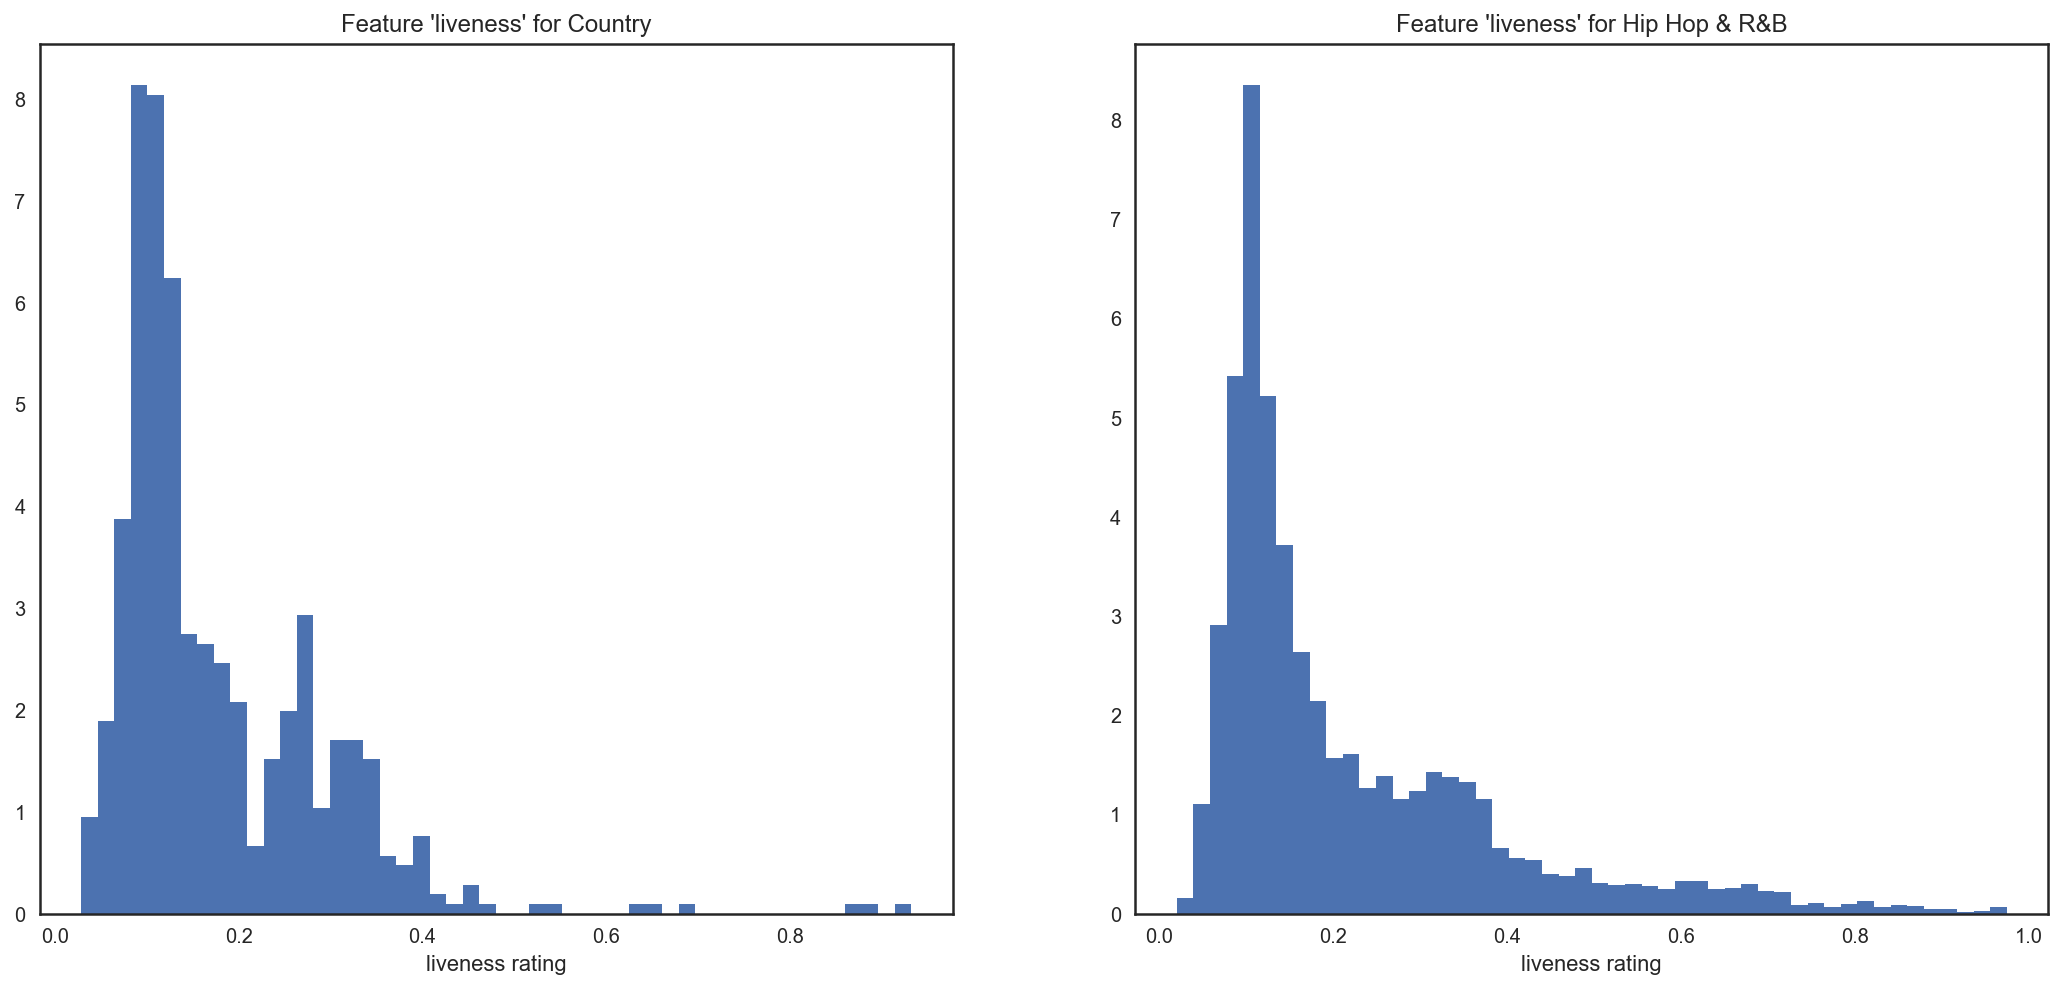

In [318]:
hist_of_feature('liveness', country_features, hiphop_features);

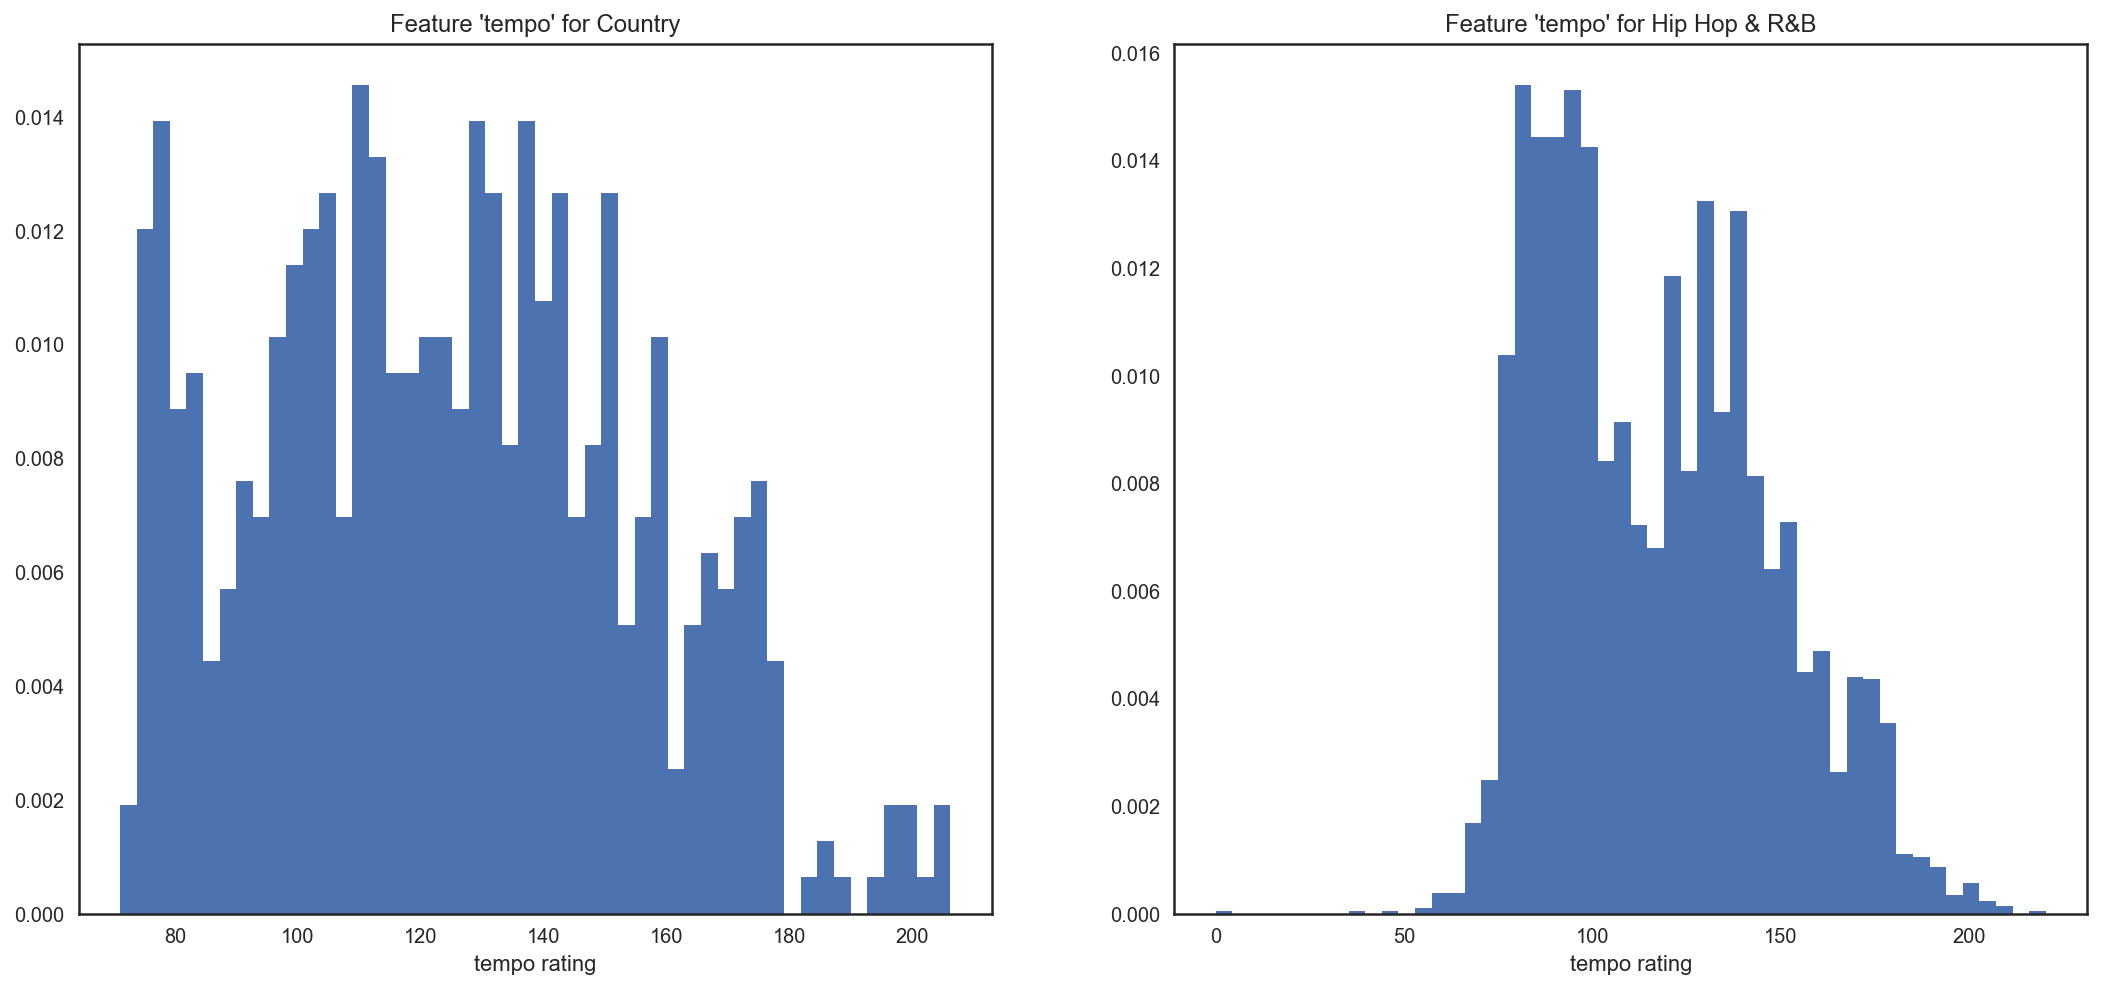

In [319]:
hist_of_feature('tempo', country_features, hiphop_features);

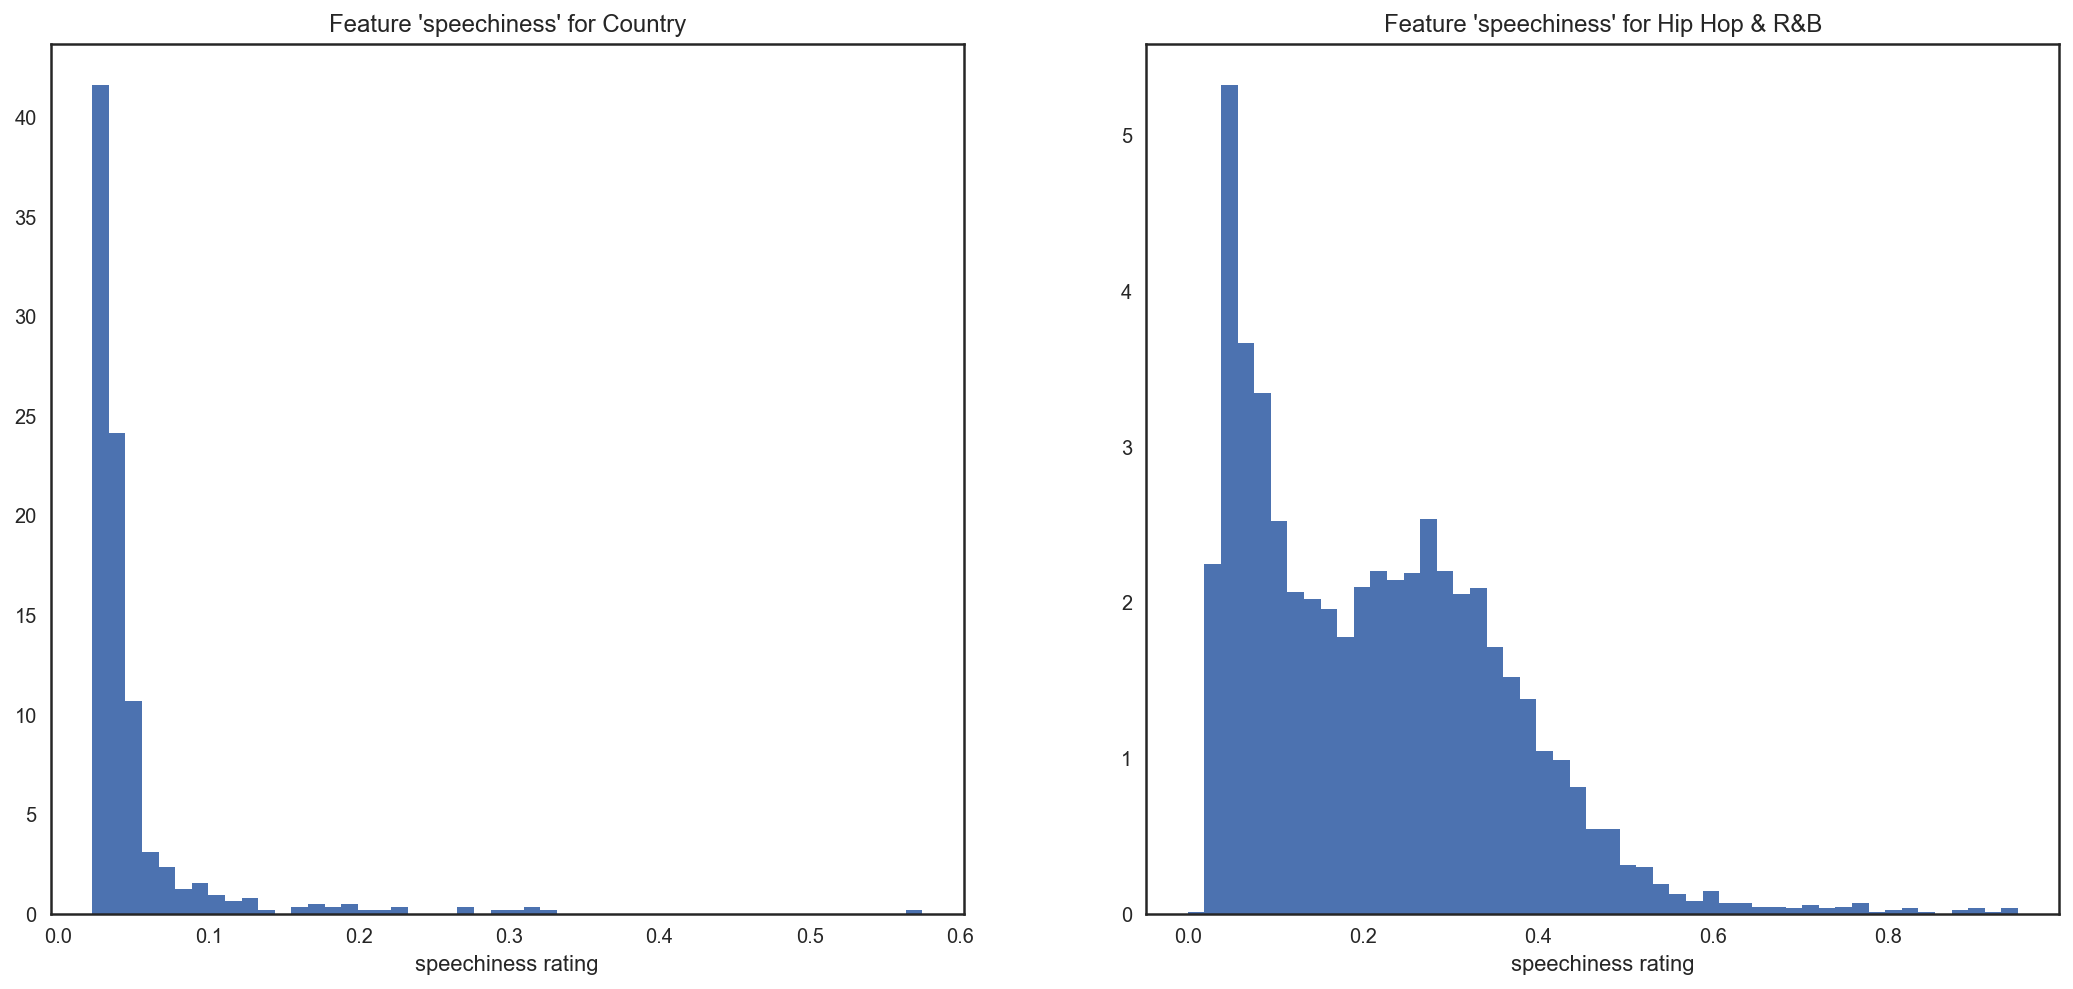

In [321]:
hist_of_feature('speechiness', country_features, hiphop_features);

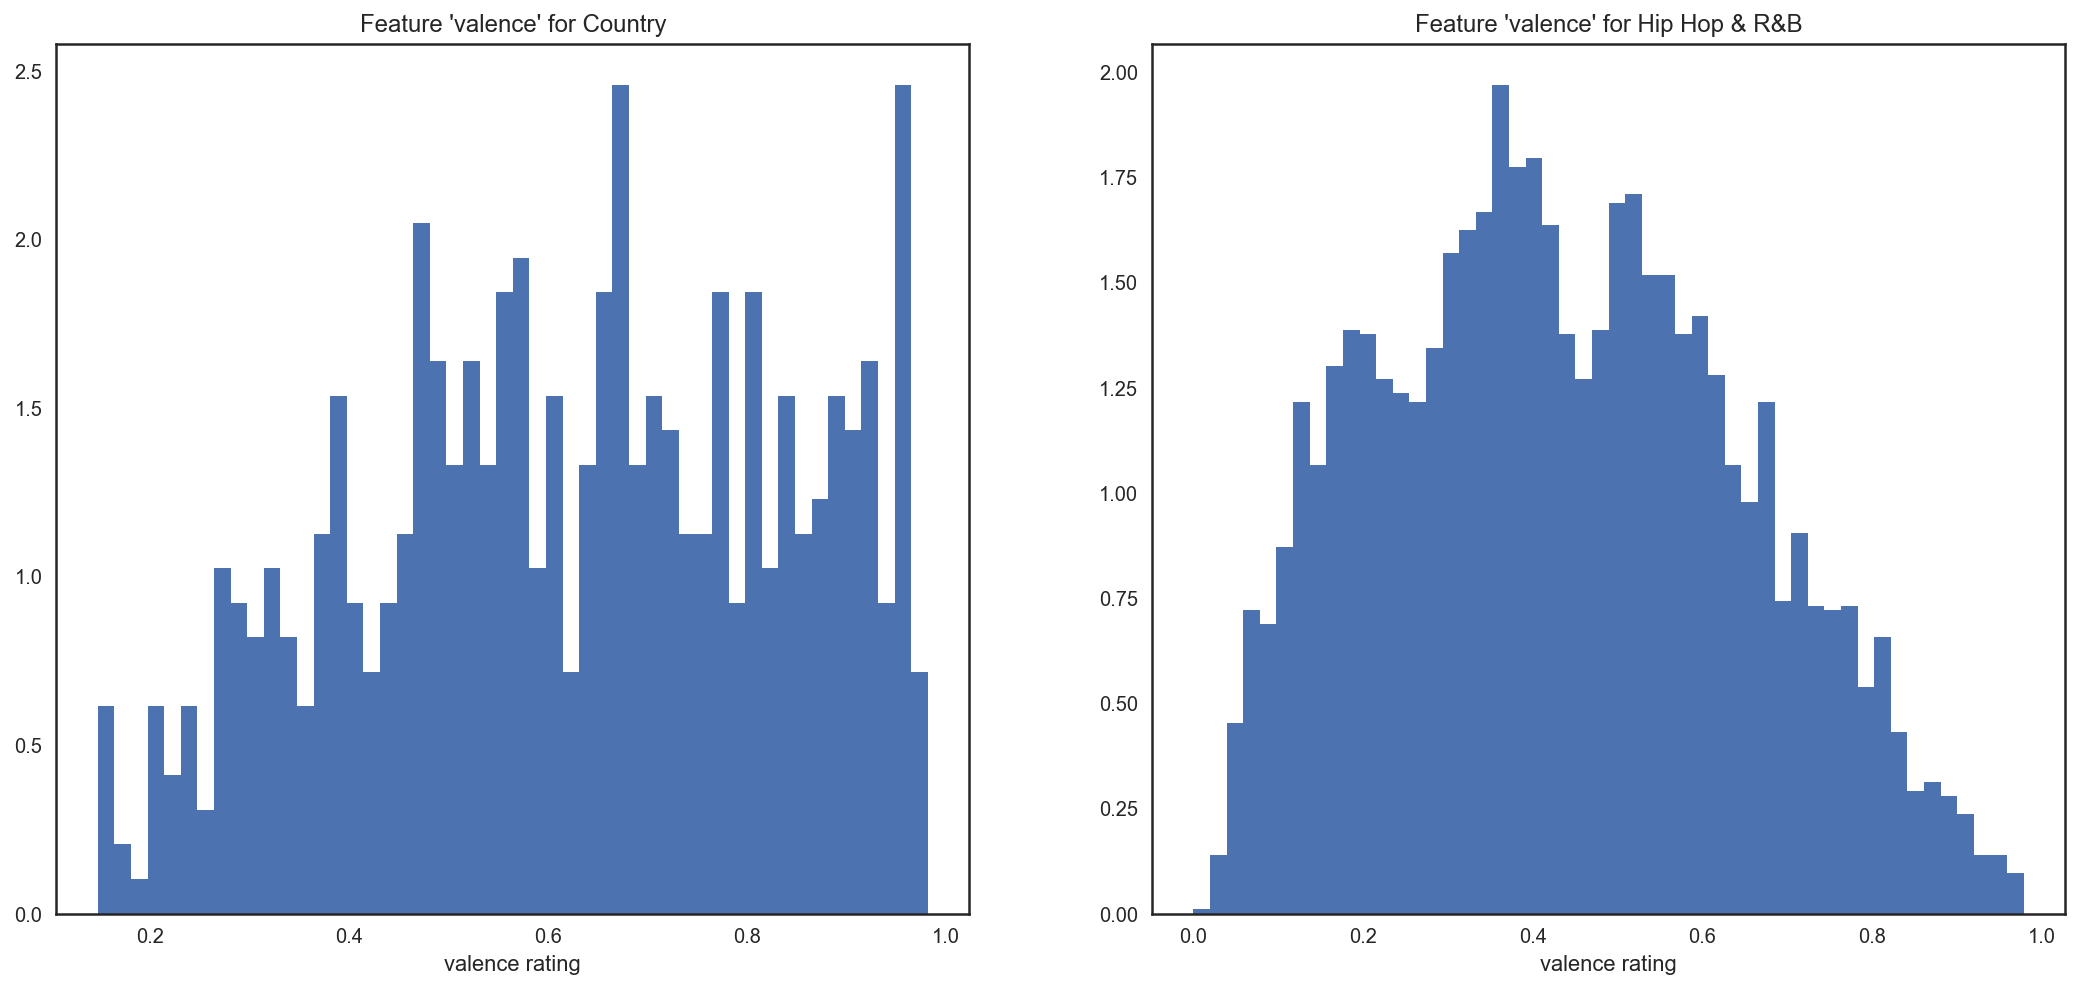

In [322]:
hist_of_feature('valence', country_features, hiphop_features);

In [83]:
import re
from collections import Counter, defaultdict


# Artist_collaboration_network[artist][collaborations] (directional graph)
def collaborating_artists(track):
    return [collab_artist['name'] for collab_artist in track['track']['artists']]
   

def collaboration_network(tracks):
    collab_network = defaultdict(Counter)
    
    for t in tracks:
        collabs = collaborating_artists(t)
        
        if len(collabs) > 1: #single list is artist itself
            for artist in collabs:
                collab_network[artist].update({c : 1 for c in collabs if c is not artist})

    return collab_network

collab_hiphop   = collaboration_network(hip_hop)
collab_country  = collaboration_network(country_1)
collab_country.update(collaboration_network(country_2))

In [116]:
def get_random_sample(genre, iters = 20):
    
    query = s.search(q='genre:{0}'.format(genre))
    tracks = []
    
    i = 0
    
    while query['tracks']['next']:
        tracks.extend(query['tracks']['items'])
        query = s.next(query['tracks'])
        
        i += 1
        
        if i == iters:
            break
  
    return tracks

In [117]:
sample = get_random_sample('rock', 100)